# Model Tuning: Random Forest and XGBoost
Based on the performance of our baseline models (Logistic Regression, SVM, Random Forest, and XGBoost), **Random Forest and XGBoost clearly outperform the others**, particularly in handling the minority class. As such, we focus our tuning efforts on these two tree-based models, as well as a **stacked ensemble method** that combines both Random Forest and XGBoost.

We begin by retraining the XGBoost, Random Forest, and stacked models on training datasets processed using four different resampling strategies: **no resampling, SMOTE, SMOTEENN, and Borderline SMOTE**. Each variation is evaluated using **PRC AUC**, which assesses the model's ability to distinguish between classes under class imbalance.

From these results, we identify the best-performing model and resampling strategy to proceed with **hyperparameter tuning and threshold calibration**. Our tuning will prioritize **recall and F1-score of the minority class (Bad credit)**, due to the high cost of misclassifying high-risk applicants — such misclassifications can result in substantial financial losses for lenders. Therefore, we aim to build a model that maximizes sensitivity to risk without compromising overall classification quality.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score, accuracy_score,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline

# Load datasets
train_no_smote = pd.read_csv('../data/processed/train_set.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

### Random Forest Base Model
We evaluate the performance of a baseline Random Forest model with No SMOTE, SMOTE, SMOTEENN, and Borderline SMOTE


--- No SMOTE ---
Accuracy: 0.8409215578716401
Confusion Matrix:
[[ 281  360]
 [ 800 5851]]
Classification Report:
              precision    recall  f1-score   support

         Bad       0.26      0.44      0.33       641
        Good       0.94      0.88      0.91      6651

    accuracy                           0.84      7292
   macro avg       0.60      0.66      0.62      7292
weighted avg       0.88      0.84      0.86      7292


--- SMOTE ---
Accuracy: 0.8712287438288535
Confusion Matrix:
[[ 238  403]
 [ 536 6115]]
Classification Report:
              precision    recall  f1-score   support

         Bad       0.31      0.37      0.34       641
        Good       0.94      0.92      0.93      6651

    accuracy                           0.87      7292
   macro avg       0.62      0.65      0.63      7292
weighted avg       0.88      0.87      0.88      7292


--- SMOTEENN ---
Accuracy: 0.834339001645639
Confusion Matrix:
[[ 239  402]
 [ 806 5845]]
Classification Report:
     

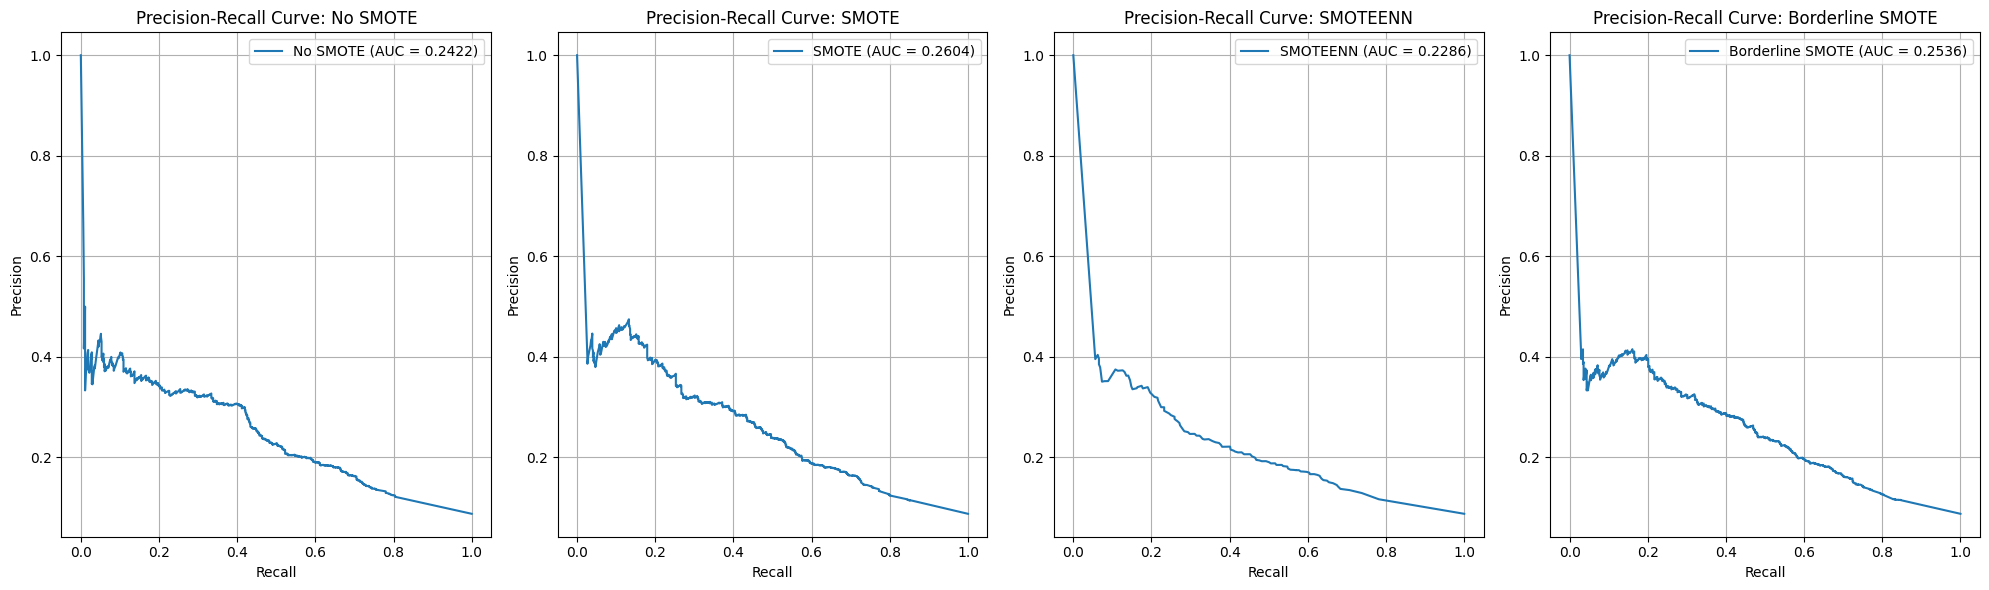

In [9]:
# Function to apply resampling
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:  # No resampling
        return train_df

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
    resampled_df["credit_status"] = y_resampled
    return resampled_df

# Function to evaluate and collect metrics, PR curve data for different models
def evaluate_and_get_pr_data(train_df, test_df, title="Model"):
    X_train = train_df[feature_columns]
    y_train = train_df["credit_status"]
    X_test = test_df[feature_columns]
    y_test = test_df["credit_status"]

    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Classification Report and Metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Encode for PR Curve
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    bad_index = list(le.classes_).index('Bad')
    y_scores = rf.predict_proba(X_test)[:, bad_index]

    precision, recall, _ = precision_recall_curve(y_test_encoded, y_scores, pos_label=bad_index)
    pr_auc = auc(recall, precision)

    # Return both PR curve data and performance metrics
    return {
        "title": title,
        "precision": precision,
        "recall": recall,
        "pr_auc": pr_auc,
        "accuracy": accuracy,
        "conf_matrix": conf_matrix,
        "class_report": class_report
    }

# Gather PR curve data and metrics for different resampling methods
results = []
results.append(evaluate_and_get_pr_data(train_no_smote, test_set, title="No SMOTE"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "SMOTE"), test_set, title="SMOTE"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "SMOTEENN"), test_set, title="SMOTEENN"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "BorderlineSMOTE"), test_set, title="Borderline SMOTE"))

# Create subplots to display PR curves side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns
for i, result in enumerate(results):
    # Display metrics (Accuracy, Confusion Matrix, and Classification Report)
    print(f"\n--- {result['title']} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])

    # Plot PR Curve
    ax = axes[i]  # Get the subplot axis
    ax.plot(result["recall"], result["precision"], label=f'{result["title"]} (AUC = {result["pr_auc"]:.4f})')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve: {result['title']}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### XGBoost Base Model
We evaluate the performance of a baseline XGBoost model with No SMOTE, SMOTE, SMOTEENN, and Borderline SMOTE


--- XGBoost (No SMOTE) ---
Accuracy: 0.9094898518924849
Confusion Matrix:
[[  23  618]
 [  42 6609]]
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.04      0.07       641
           1       0.91      0.99      0.95      6651

    accuracy                           0.91      7292
   macro avg       0.63      0.51      0.51      7292
weighted avg       0.87      0.91      0.87      7292


--- XGBoost (SMOTE) ---
Accuracy: 0.8690345584201865
Confusion Matrix:
[[ 143  498]
 [ 457 6194]]
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.22      0.23       641
           1       0.93      0.93      0.93      6651

    accuracy                           0.87      7292
   macro avg       0.58      0.58      0.58      7292
weighted avg       0.87      0.87      0.87      7292


--- XGBoost (SMOTEENN) ---
Accuracy: 0.8853538123971476
Confusion Matrix:
[[  72  569]
 [ 267 6384

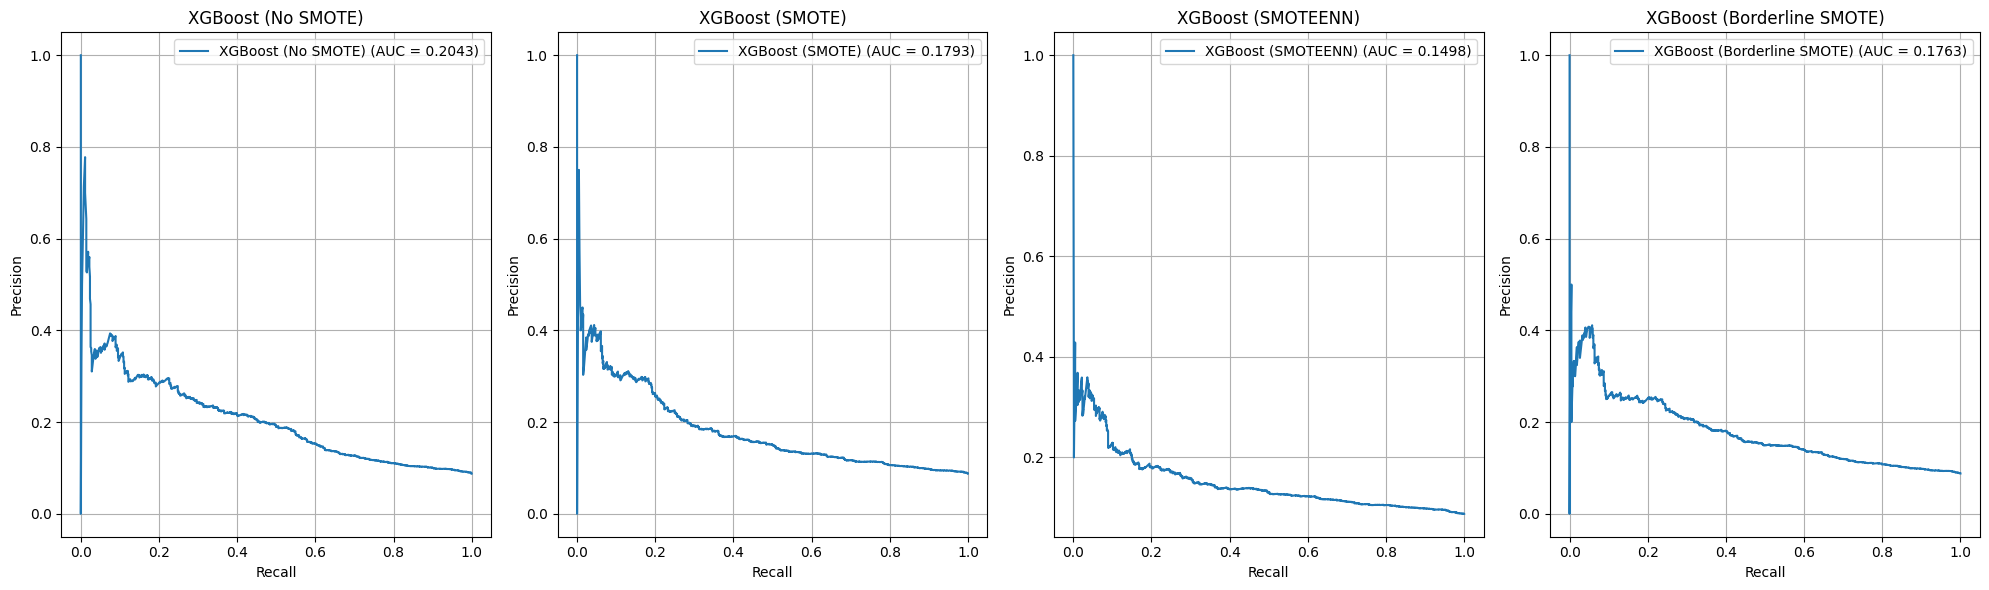

In [4]:
# Function to apply resampling
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:  # No resampling
        return train_df

    X_res, y_res = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_res, columns=feature_columns)
    resampled_df["credit_status"] = y_res
    return resampled_df

# Function to evaluate and collect metrics + PR curve data using XGBoost
def evaluate_xgb_model(train_df, test_df, title="XGBoost Model"):
    le = LabelEncoder()
    y_train = le.fit_transform(train_df["credit_status"])
    y_test = le.transform(test_df["credit_status"])
    bad_index = list(le.classes_).index("Bad")

    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]

    xgb = XGBClassifier(eval_metric='logloss')
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    # Collect metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # PR curve data
    y_probs = xgb.predict_proba(X_test)[:, bad_index]
    y_test_binary = (y_test == bad_index).astype(int)
    precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
    prc_auc = auc(recall, precision)

    return {
        "title": title,
        "precision": precision,
        "recall": recall,
        "pr_auc": prc_auc,
        "accuracy": accuracy,
        "conf_matrix": conf_matrix,
        "class_report": class_report
    }

# Gather results for all 4 versions
xgb_results = []
xgb_results.append(evaluate_xgb_model(train_no_smote, test_set, title="XGBoost (No SMOTE)"))
xgb_results.append(evaluate_xgb_model(apply_resampling(train_no_smote, "SMOTE"), test_set, title="XGBoost (SMOTE)"))
xgb_results.append(evaluate_xgb_model(apply_resampling(train_no_smote, "SMOTEENN"), test_set, title="XGBoost (SMOTEENN)"))
xgb_results.append(evaluate_xgb_model(apply_resampling(train_no_smote, "BorderlineSMOTE"), test_set, title="XGBoost (Borderline SMOTE)"))

# Plot PR curves side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns
for i, result in enumerate(xgb_results):
    # Print metrics
    print(f"\n--- {result['title']} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])

    # Plot PR Curve
    ax = axes[i]
    ax.plot(result["recall"], result["precision"], label=f'{result["title"]} (AUC = {result["pr_auc"]:.4f})')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(result['title'])
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### Stacking Base Model: Combining Random Forest and XGBoost
We evaluate the performance of a baseline stacked RF and XGB model with No SMOTE, SMOTE, SMOTEENN, and Borderline SMOTE


--- Stacking (No SMOTE) ---
Accuracy: 0.912095447065277
Confusion Matrix:
 [[   5  636]
 [   5 6646]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.50      0.01      0.02       641
        Good       0.91      1.00      0.95      6651

    accuracy                           0.91      7292
   macro avg       0.71      0.50      0.48      7292
weighted avg       0.88      0.91      0.87      7292


--- Stacking (SMOTE) ---
Accuracy: 0.8775370268787712
Confusion Matrix:
 [[ 200  441]
 [ 452 6199]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.31      0.31      0.31       641
        Good       0.93      0.93      0.93      6651

    accuracy                           0.88      7292
   macro avg       0.62      0.62      0.62      7292
weighted avg       0.88      0.88      0.88      7292


--- Stacking (SMOTEENN) ---
Accuracy: 0.8391387822270981
Confusion Matrix:
 [[ 226  415]
 [ 7

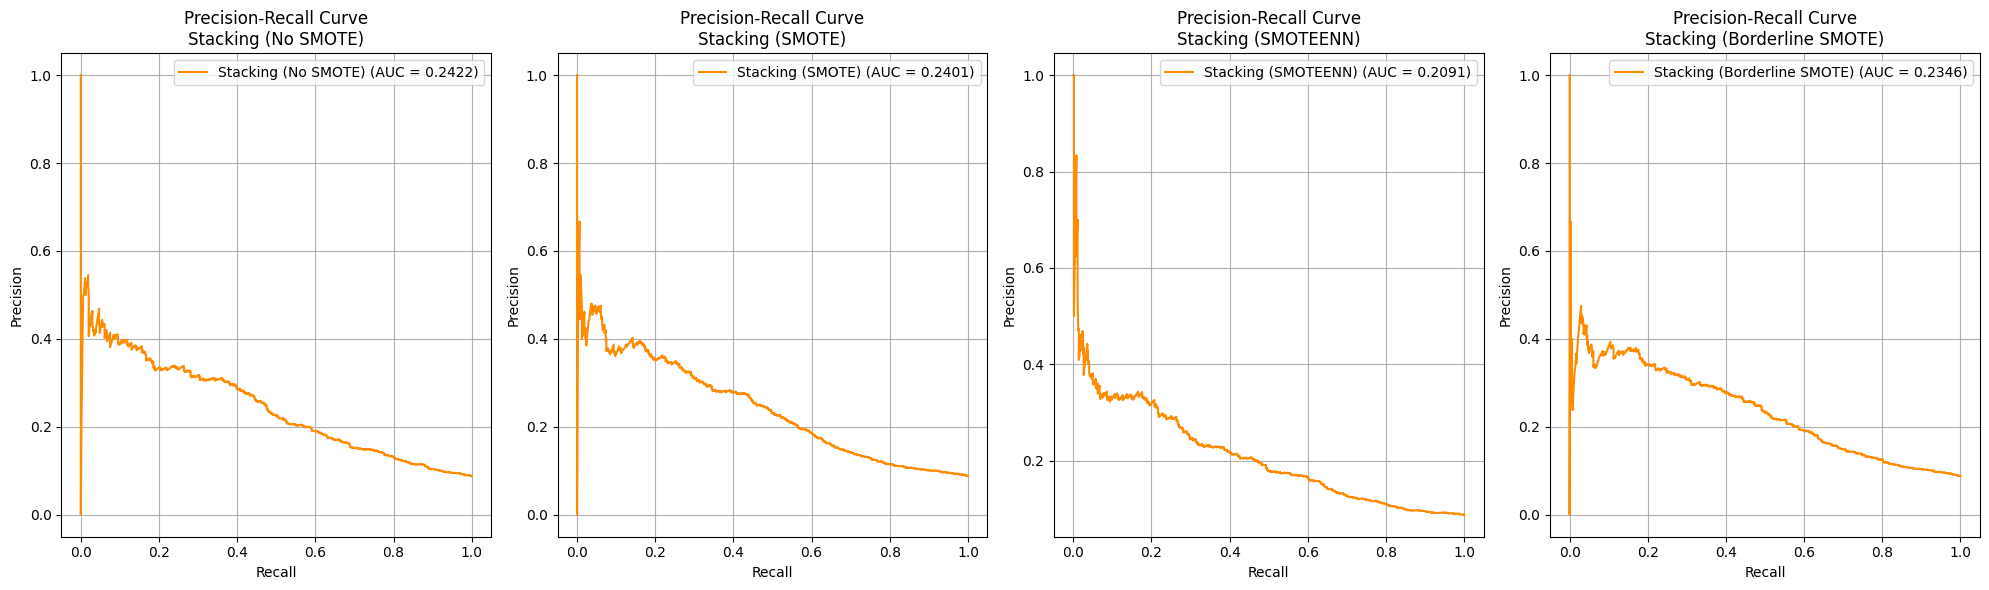

In [5]:
# Define reusable resampling function
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:
        return train_df  # No resampling

    X_res, y_res = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_res, columns=feature_columns)
    resampled_df["credit_status"] = y_res
    return resampled_df

# Unified evaluation function
def evaluate_stacking_model(train_df, test_df, title="Stacking Model"):
    # Encode target
    le = LabelEncoder()
    y_train = le.fit_transform(train_df["credit_status"])
    y_test = le.transform(test_df["credit_status"])
    bad_index = list(le.classes_).index("Bad")

    # Feature matrices
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]

    # Define stacking classifier
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    xgb = XGBClassifier(eval_metric='logloss')

    stacking_model = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb)],
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=True,
        n_jobs=-1
    )

    # Train and predict
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    y_probs = stacking_model.predict_proba(X_test)[:, bad_index]

    # Binary indicator for "Bad" class
    y_test_binary = (y_test == bad_index).astype(int)

    # PRC computation
    precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
    prc_auc = auc(recall, precision)

    # Print metrics
    print(f"\n--- {title} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Return for plotting
    return {
        "title": title,
        "precision": precision,
        "recall": recall,
        "pr_auc": prc_auc,
        "accuracy": accuracy_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred),
        "class_report": classification_report(y_test, y_pred, target_names=le.classes_)
    }

# Run evaluations
results = []
results.append(evaluate_stacking_model(train_no_smote, test_set, title="Stacking (No SMOTE)"))
results.append(evaluate_stacking_model(apply_resampling(train_no_smote, "SMOTE"), test_set, title="Stacking (SMOTE)"))
results.append(evaluate_stacking_model(apply_resampling(train_no_smote, "SMOTEENN"), test_set, title="Stacking (SMOTEENN)"))
results.append(evaluate_stacking_model(apply_resampling(train_no_smote, "BorderlineSMOTE"), test_set, title="Stacking (Borderline SMOTE)"))

# Plot PR Curves
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns
for i, result in enumerate(results):
    print(f"\n--- {result['title']} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])

    ax = axes[i]
    ax.plot(result["recall"], result["precision"], label=f'{result["title"]} (AUC = {result["pr_auc"]:.4f})', color='darkorange')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve\n{result['title']}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



## Tuning Random Forest Model

Based on the results, the **Random Forest model trained with regular SMOTE** stood out. It achieved one of the highest **PRC AUC scores** and demonstrated a strong balance between recall and precision for the minority class. Given its relative strength in identifying high-risk applicants, we selected this model for further tuning to enhance its ability to detect risky credit profiles more effectively.

We begin by performing **hyperparameter tuning**, which was done in two stages. First, we compared two optimization strategies:

- Tuning the model to **maximize recall**, and
- Tuning to **maximize F1-score**.

From there, we proceeded with **threshold tuning**, further optimizing the classification decision boundary to improve the model’s sensitivity to high-risk applicants.

In [12]:
# Load datasets
train_set = pd.read_csv('../data/processed/train_set_SMOTEd.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

### 1. Hyperparameter Tuning 
The grid search explored a wide range of parameters that influence both model complexity and sampling behavior: 

- `n_estimators`: Number of trees in the forest (100, 200): A higher number generally improves stability and performance, but increases computational cost. Values of 100 and 200 were chosen to balance model performance with training time. 

- `max_depth`: Maximum depth of each tree (None, 10, 20): Shallow trees reduce overfitting, while deeper trees can capture more complex patterns. Including None allows trees to grow until pure, while 10 and 20 test controlled depths. 

- `min_samples_split`: Minimum number of samples required to split an internal node (2, 5): A higher value prevents the model from creating overly specific splits, reducing the risk of overfitting on noise. 

- `min_samples_leaf`: Minimum number of samples required at a leaf node (1, 2): A value of 1 allows maximum granularity, while 2 encourages slightly more general splits to enhance robustness. 

- `max_features`: Number of features to consider when looking for the best split (sqrt, log2): These are common best practices for classification tasks in Random Forest, helping to introduce randomness and reduce correlation among trees. 

- `bootstrap`: Specifies whether bootstrapping is used to draw training samples for each tree (True, False): Bootstrapping introduces diversity among trees, while disabling it forces trees to use the full dataset, providing a basis for comparison. 

The inclusion of both sampling and structural hyperparameters ensured that the tuning process accounted for both overfitting control and bias-variance trade-off, as well as sensitivity to the skewed class distribution. 


#### 1.a. Maximising Recall

Best Parameters: {'clf__bootstrap': False, 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Classification Report (Bad = 1):
              precision    recall  f1-score   support

        Good       0.94      0.85      0.89      6651
         Bad       0.22      0.45      0.30       641

    accuracy                           0.81      7292
   macro avg       0.58      0.65      0.60      7292
weighted avg       0.88      0.81      0.84      7292

Confusion Matrix:
[[5653  998]
 [ 354  287]]
PRC AUC: 0.2209


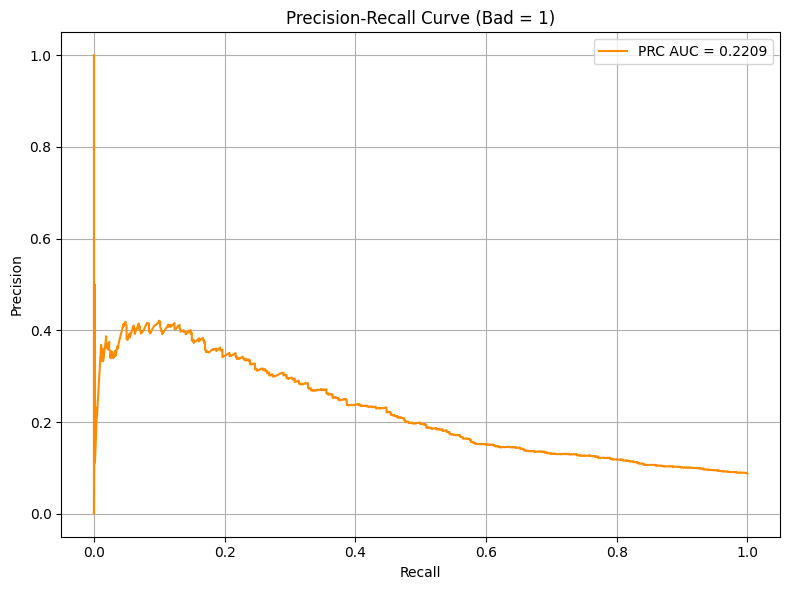

In [18]:
### WARNING: WILL RUN FOR ~ 20 MINUTES

# Build pipeline
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    #'clf__max_samples': [None, 0.8, 0.6],
    #'clf__class_weight': [None, 'balanced']
}

# Use Recall score where 'Bad' is positive class (1)
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=recall_scorer,
    n_jobs=-1,
    verbose=0
)

# Fit model
grid_search.fit(X_train, y_train)
pipeline = grid_search.best_estimator_

# Predict with best model using default threshold = 0.5
y_pred = pipeline.predict(X_test)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### 1.b. Maximising F1

Best Parameters: {'clf__bootstrap': False, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Classification Report (Bad = 1):
              precision    recall  f1-score   support

        Good       0.94      0.93      0.93      6651
         Bad       0.31      0.33      0.32       641

    accuracy                           0.87      7292
   macro avg       0.62      0.63      0.62      7292
weighted avg       0.88      0.87      0.88      7292

Confusion Matrix:
[[6166  485]
 [ 428  213]]
PRC AUC: 0.2764


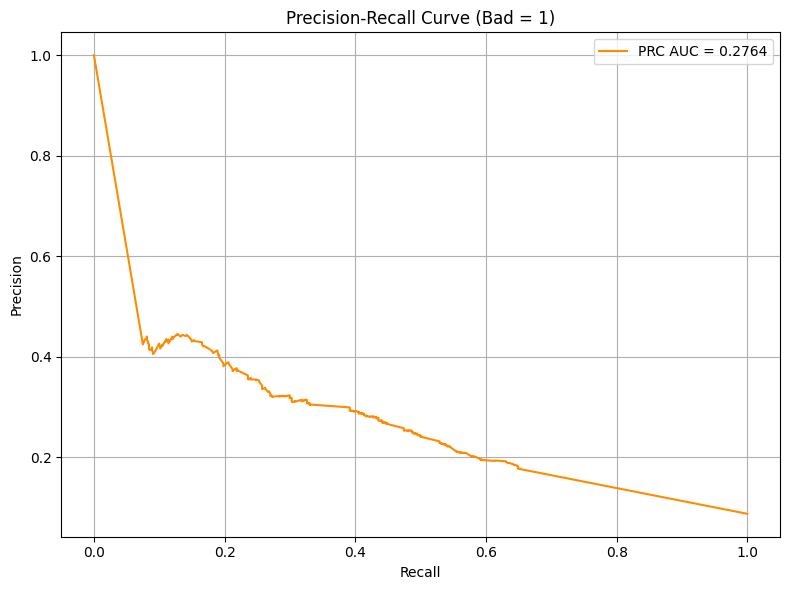

In [19]:
### WARNING: WILL RUN FOR ~ 20 MINUTES

# Build pipeline
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
}

# Use F1 score where 'Bad' is positive class (1)
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=0
)

# Fit model
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Use best estimator
pipeline = grid_search.best_estimator_

# Predict with default threshold = 0.5
y_pred = pipeline.predict(X_test)

# Evaluation
print("Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 2. Threshold Tuning
For each set of optimized hyperparameters, we further refined the model by tuning the classification threshold. Rather than using the default threshold of 0.5, we systematically searched for a decision threshold that better balances precision and recall for the minority class ("Bad").

To ensure the model remains effective at identifying high-risk cases, we imposed a constraint during this tuning step:

- Recall for the "Bad" class must be ≥ 0.50

Among the thresholds satisfying this condition, we selected the one that **maximizes the F1 score**, ensuring a strong trade-off between precision and recall. This approach enhances the model’s ability to detect risky applicants while maintaining a manageable false positive rate.

#### 2.a. Using best hyperparameters from 1.a.

Selected Threshold (Recall ≥ 0.5): 0.464
Precision: 0.196, Recall: 0.504, F1: 0.283
Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.94      0.80      0.87      6651
         Bad       0.20      0.50      0.28       641

    accuracy                           0.78      7292
   macro avg       0.57      0.65      0.57      7292
weighted avg       0.88      0.78      0.82      7292

Confusion Matrix:
[[5329 1322]
 [ 318  323]]
Best Threshold: 0.464
PRC AUC: 0.2209


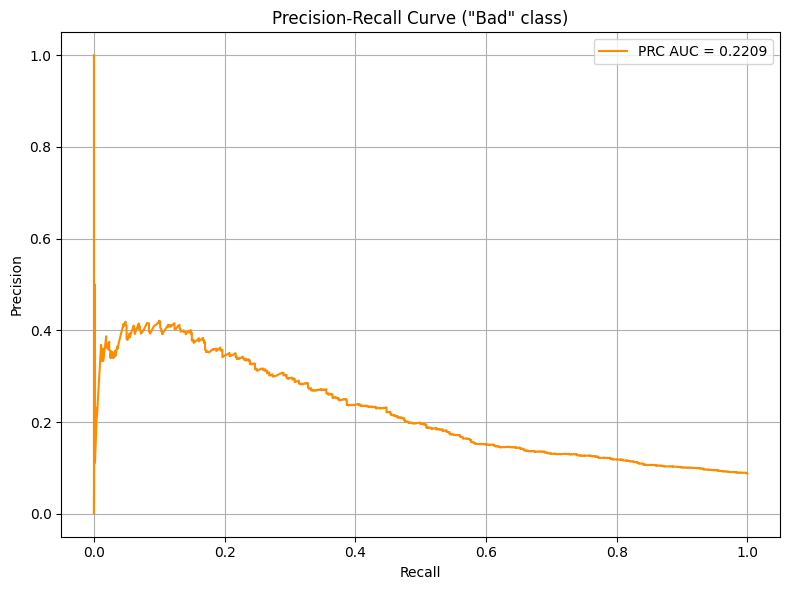

Top Features:
                                         Feature  Importance
0                              log_annual_income    0.202094
1                                            age    0.179235
2                             log_years_employed    0.117654
3                                    family_size    0.066686
4                                        own_car    0.026745
5                                     own_realty    0.024422
6                                          phone    0.024072
7                                         gender    0.021867
8                          family_status_Married    0.021357
9                            income_type_Working    0.021299
10                                    work_phone    0.019762
11  education_type_Secondary / secondary special    0.018358
12                housing_type_House / apartment    0.017957
13                             occupation_Others    0.017818
14               education_type_Higher education    0.017570


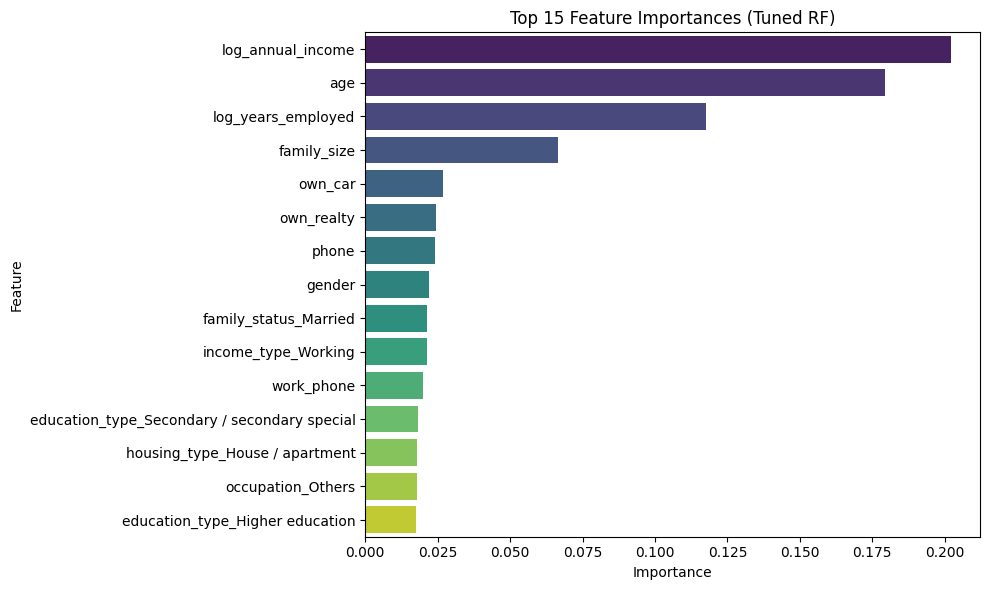

In [21]:
# Use best model parameters directly
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = 20,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = False,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', hue='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 2.b. Using best hyperparametrs from 1.b.

Selected Threshold (Recall ≥ 0.5): 0.257
Precision: 0.242, Recall: 0.501, F1: 0.327
Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.95      0.85      0.90      6651
         Bad       0.24      0.50      0.33       641

    accuracy                           0.82      7292
   macro avg       0.59      0.67      0.61      7292
weighted avg       0.88      0.82      0.85      7292

Confusion Matrix:
[[5647 1004]
 [ 320  321]]
Best Threshold: 0.257
PRC AUC: 0.2764


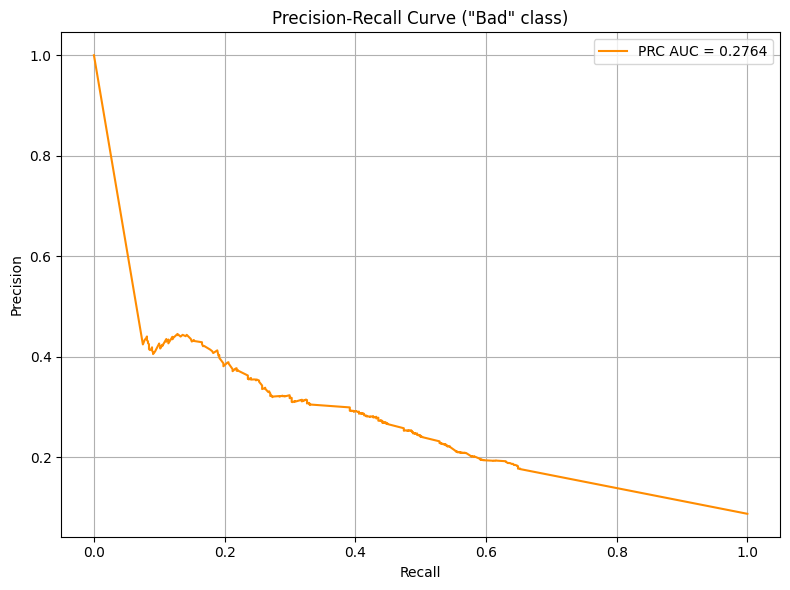

Top Features:
                                         Feature  Importance
0                              log_annual_income    0.222927
1                                            age    0.210998
2                             log_years_employed    0.136027
3                                    family_size    0.057810
4                                        own_car    0.026955
5                                          phone    0.022666
6                                         gender    0.021368
7                            income_type_Working    0.019653
8                                     own_realty    0.019447
9                                     work_phone    0.017699
10                             occupation_Others    0.016760
11                         family_status_Married    0.015379
12  education_type_Secondary / secondary special    0.015294
13                           occupation_Laborers    0.014889
14               education_type_Higher education    0.014692


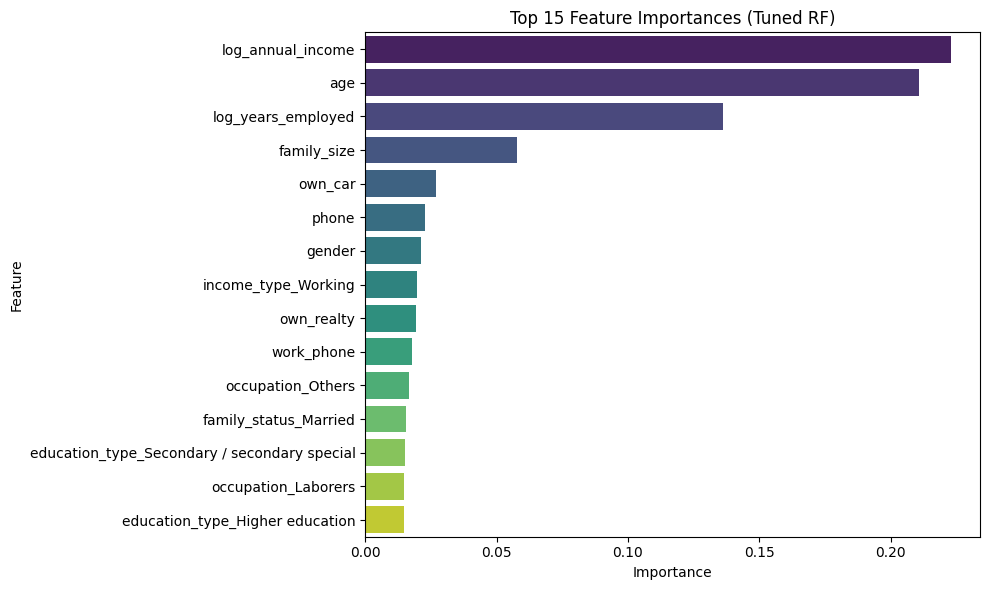

In [22]:
# Use best model parameters directly
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = False,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', hue='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Threshold Tuning Analysis (Recall ≥ 0.5)

Based on the results, the **Random Forest model using SMOTE performed best when hyperparameters were tuned to maximize F1-score**, followed by threshold tuning with a minimum recall constraint (Recall ≥ 0.5).

| Metric              | Max Recall Tuning | Max F1 Tuning |
|---------------------|-------------------|----------------|
| **Selected Threshold** | 0.464             | 0.257          |
| **Precision (Bad)**    | 0.20             | **0.24**      |
| **Recall (Bad)**       | 0.50             | 0.50          |
| **F1-score (Bad)**     | 0.28             | **0.32**      |
| **PRC AUC**            | 0.2209            | **0.2764**     |


The F1-tuned model achieved a **better balance between precision and recall**, yielding a higher F1-score for the minority "Bad" class while still meeting the minimum recall requirement. It also showed a **higher overall PRC AUC**, indicating better ranking performance.


Output results for analysis

In [24]:
# Add predictions to test set
test_set['predicted_credit_status'] = y_pred_custom
test_set['credit_status'] = y_test_binary

# Save the test set with predictions
test_set.to_csv('test_set_with_predictions.csv', index=False)